아래는 백화점 고객의 1년간 구매 데이터이다.

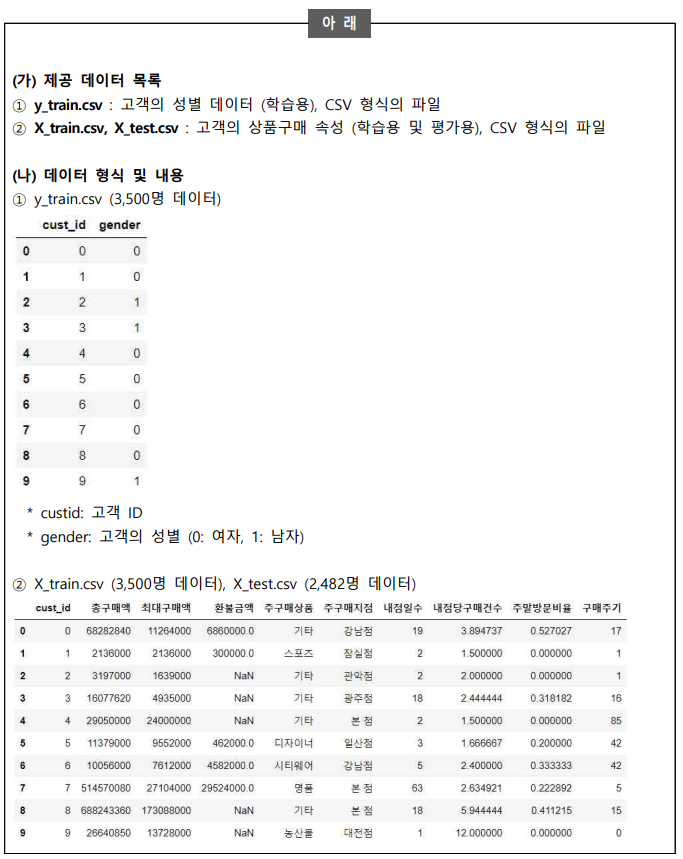

고객 3,500명에 대한 학습용 데이터(y_train.csv, X_train.csv)를 이용하여 성별예측 모형을 만든 후, 이를 평가용 데이터(X_test.csv)에 적용하여 얻은 2,482명 고객의 성별 예측값(남자일 확률)을 다음과 같은 형식의 csv 파일로 생성하시오. (제출한 모델의 성능은 ROC-AUC 평가지표에 따라 채점)

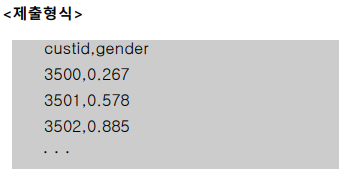

유의 사항

성능이 우수한 예측 모형을 구축하기 위해서는 적절한 데이터 전처리, Feature Engineering, 분류 알고리즘 사용, 초매개변수 최적화, 모형 앙상블 등이 수반되어야 한다.

In [ ]:
!git clone https://github.com/Soyoung-Yoon/bigdata

Cloning into 'bigdata'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 62 (delta 3), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (62/62), 14.49 MiB | 2.36 MiB/s, done.


In [ ]:
import pandas as pd

pd.options.display.max_rows = 500     
pd.options.display.max_columns = 20   
#출력 format 지정 - 소수점아래 4자리까지
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
# 학습 데이터 X_train.csv 가져오기
X = pd.read_csv('bigdata/X_train.csv', encoding='cp949')
print(X.head(2))

   cust_id      총구매액     최대구매액         환불금액 주구매상품 주구매지점  내점일수  내점당구매건수  \
0        0  68282840  11264000 6860000.0000    기타   강남점    19   3.8947   
1        1   2136000   2136000  300000.0000   스포츠   잠실점     2   1.5000   

   주말방문비율  구매주기  
0  0.5270    17  
1  0.0000     1  


In [ ]:
#  학습 데이터 y_train.csv 가져오기
Y = pd.read_csv('bigdata/y_train.csv')
print(Y.head(2))

   cust_id  gender
0        0       0
1        1       0


In [ ]:
# 제출용 데이터 X_test.csv 가져오기
X_submission = pd.read_csv('bigdata/X_test.csv', encoding='cp949')
print(X_submission.head(2))

   cust_id       총구매액     최대구매액          환불금액 주구매상품 주구매지점  내점일수  내점당구매건수  \
0     3500   70900400  22000000  4050000.0000    골프  부산본점    13   1.4615   
1     3501  310533100  38558000 48034700.0000   농산물   잠실점    90   2.4333   

   주말방문비율  구매주기  
0  0.7895    26  
1  0.3699     3  


### 2-03.데이터전처리

In [ ]:
# X, X_submission에 동일한 전처리를 위해 두 데이터 결합하여
# dfX로 이름 붙이기
dfX = pd.concat([X, X_submission], axis=0, ignore_index=True)
print(dfX.tail(2))

      cust_id      총구매액     최대구매액  환불금액 주구매상품 주구매지점  내점일수  내점당구매건수  주말방문비율  \
5980     5980  88991520  18120000   NaN    육류  본  점     5   3.6000  0.4444   
5981     5981    623700    209000   NaN  가공식품  영등포점     2   5.0000  0.0000   

      구매주기  
5980    60  
5981    31  


In [ ]:
# 각 컬럼의 dtype 및 행, 열 개수 확인
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  5982 non-null   int64  
 1   총구매액     5982 non-null   int64  
 2   최대구매액    5982 non-null   int64  
 3   환불금액     2076 non-null   float64
 4   주구매상품    5982 non-null   object 
 5   주구매지점    5982 non-null   object 
 6   내점일수     5982 non-null   int64  
 7   내점당구매건수  5982 non-null   float64
 8   주말방문비율   5982 non-null   float64
 9   구매주기     5982 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 467.5+ KB


In [ ]:
# dfX의 컬럼별 결측치 확인하기
print(dfX.isna().sum())

cust_id       0
총구매액          0
최대구매액         0
환불금액       3906
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64


In [ ]:
# 결측치를 채우기 위한 값 선정을 위한 작업
# 주구매상품별로 환불금액 평균이 다름을 확인
temp = dfX.groupby('주구매상품')['환불금액'].mean()
print(temp)

In [ ]:
dfX['주구매상품'].head(5)

0        기타
1       스포츠
2    남성 캐주얼
3        기타
4        보석
Name: 주구매상품, dtype: object

In [ ]:
# '주구매상품'별 '환불금액' 평균으로 '환불금액'의 결측치를 채우기 
# 채우기 한 뒤 '환불금액'으로 추가
temp = dfX.groupby('주구매상품')['환불금액'].transform('mean')
# dfX['환불금액']의 결측치를 temp로 채우기
dfX['환불금액'] = dfX['환불금액'].mask(dfX['환불금액'].isna(), temp)

In [ ]:
# 환불금액' 컬럼의 결측치 행을 확인해 본다
# 주구매상품 중에서 '통신/컴퓨터', '소형가전', '악기' 채워지지 않음
dfX[dfX['환불금액'].isna()]

In [ ]:
# '주구매상품'별 평균을 구할 수 없는 경우
# '환불금액'을 '환불금액'의 평균으로 채우기 합니다.
dfX['환불금액'] = dfX['환불금액'].fillna(dfX['환불금액'].mean())
print(dfX.isna().sum().sum())

0


In [ ]:
#  dfX에서 높은 상관계수 확인하기 (X Feature간)
# 상관관계가 높은 X1, X2가 있다면 제거 : -1 또는 1에 가까운 것은 좋지 않음
(dfX.corr(numeric_only=True))

,cust_id,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,주말방문비율,구매주기
cust_id,1.0000,0.0206,0.0210,0.0032,-0.0017,-0.0055,-0.0179,-0.0029
총구매액,0.0206,1.0000,0.6826,0.4013,0.6484,0.1050,0.0160,-0.2126
최대구매액,0.0210,0.6826,1.0000,0.3227,0.3602,0.0291,0.0163,-0.1128
환불금액,0.0032,0.4013,0.3227,1.0000,0.5000,0.0674,-0.0066,-0.2090
내점일수,-0.0017,0.6484,0.3602,0.5000,1.0000,0.2303,-0.0036,-0.2953
내점당구매건수,-0.0055,0.1050,0.0291,0.0674,0.2303,1.0000,0.0110,-0.0781
주말방문비율,-0.0179,0.0160,0.0163,-0.0066,-0.0036,0.0110,1.0000,-0.0135
구매주기,-0.0029,-0.2126,-0.1128,-0.2090,-0.2953,-0.0781,-0.0135,1.0000


In [ ]:
# Y['gender'] 값의 분포 확인 - 여성 (62.4%), 남성 (37.6%)
temp = Y['gender'].value_counts(normalize=True)
print(temp)

0   0.6240
1   0.3760
Name: gender, dtype: float64


In [ ]:
dfX.iloc[:3500,:].columns, Y.columns

(Index(['cust_id', '총구매액', '최대구매액', '환불금액', '주구매상품', '주구매지점', '내점일수', '내점당구매건수',
        '주말방문비율', '구매주기'],
       dtype='object'), Index(['cust_id', 'gender'], dtype='object'))

In [ ]:
# dfX.iloc[:3500,:], Y를 병합(merge)하여 dfXY를 만들어 사용
dfXY = pd.merge(dfX.iloc[:3500,:], Y)
dfXY.columns, dfXY.shape

(Index(['cust_id', '총구매액', '최대구매액', '환불금액', '주구매상품', '주구매지점', '내점일수', '내점당구매건수',
        '주말방문비율', '구매주기', 'gender'],
       dtype='object'), (3500, 11))

In [ ]:
범주별 평균의 차이가 있는지 검증
from scipy import stats

def statistical_test(mode, df, cat, target):
    uniques= df[cat].unique()

    if mode == 't':
        group = df.groupby(cat)[target]
        samples = [group.get_group(i) for i in uniques]
        value, p = stats.ttest_ind(*samples)
        return value, p, 'Statistically Signifcant' if p<=0.05 else 'Statistically Insignifcant'
    elif mode == 'f':
        group = df.groupby(cat)[target]
        samples = [group.get_group(i) for i in uniques]
        value, p = stats.f_oneway(*samples)
        return value, p, 'Statistically Signifcant' if p<=0.05 else 'Statistically Insignifcant'

# 환불금액을  환불여부를 나타내는 0, 1로 채웠을 때 gender별 평균이 유의미하게 다음
statistical_test('f', dfXY, '환불금액', 'gender')

(149.5047891988149, 1.0736788722190066e-33, 'Statistically Signifcant')

In [ ]:
#temp = pd.concat([dfX.iloc[:3500,:], Y['gender']], axis=1)
#temp.columns, temp.shape

(Index(['cust_id', '총구매액', '최대구매액', '환불금액', '주구매상품', '주구매지점', '내점일수', '내점당구매건수',
        '주말방문비율', '구매주기', 'gender'],
       dtype='object'), (3500, 11))

In [ ]:
# dfXY를 사용해 성별별 평균을 구한다.
# 'gender'에 따라 총구매액 ~ 구매주기에 값의 차이가 있는지 확인
temp = dfXY.groupby('gender').mean()
print(temp)

         cust_id           총구매액         최대구매액          환불금액    내점일수  내점당구매건수  \
gender                                                                         
0      1751.0636 110972689.2674 22502944.8672 23035538.5256 22.5229   2.9001   
1      1746.9050  60298653.4422 14953202.6140 18234312.8038 13.8283   2.7268   

        주말방문비율    구매주기  
gender                  
0       0.2907 20.1621  
1       0.3347 22.2796  


In [ ]:
# dfXY를 사용해 '주구매지점'별, 'gender'별 방문횟수를 확인
# 성별에 다른 분포가 있으므로 '주구매지점' 포함
temp = dfXY.groupby(['주구매지점', 'gender'])['주구매지점'].count()
print(temp)

In [ ]:
# dfXY를 사용해 '주구매상품'별, 'gender'별 방문횟수를 확인
# 성별에 다른 분포가 있으므로 '주구매상품' 포함
temp = dfXY.groupby(['주구매상품', 'gender'])['주구매상품'].count()
print(temp)

In [ ]:
# object dtype 이었던 '주구매지점' '주구매상품' => 숫자로 변경

In [ ]:
# [17] dfX에서 '주구매지점'에 대해 중복을 제거해 본다 (고윳값을 확인함)
A = dfX['주구매지점'].unique()
print(A)   # 명목형

['강남점' '잠실점' '관악점' '광주점' '본  점' '일산점' '대전점' '부산본점' '분당점' '영등포점' '미아점'
 '청량리점' '안양점' '부평점' '동래점' '포항점' '노원점' '창원점' '센텀시티점' '인천점' '대구점' '전주점'
 '울산점' '상인점']


In [ ]:
# dfX에서 '주구매상품'에 대해 중복을 제거해 본다 (고윳값을 확인함)
B = dfX['주구매상품'].unique()
print(B)   # 명목형

['기타' '스포츠' '남성 캐주얼' '보석' '디자이너' '시티웨어' '명품' '농산물' '화장품' '골프' '구두' '가공식품'
 '수산품' '아동' '차/커피' '캐주얼' '섬유잡화' '육류' '축산가공' '젓갈/반찬' '액세서리' '피혁잡화' '일용잡화'
 '주방가전' '주방용품' '건강식품' '가구' '주류' '모피/피혁' '남성 트랜디' '셔츠' '남성정장' '생활잡화'
 '트래디셔널' '란제리/내의' '커리어' '침구/수예' '대형가전' '통신/컴퓨터' '식기' '소형가전' '악기']


In [ ]:
# '주구매지점', '주구매상품'에 대해 Label Encoding을 실행
# 항목별 순서 개념이 없는 경우
dfX['주구매지점'] = dfX['주구매지점'].astype('category').cat.codes
dfX['주구매상품'] = dfX['주구매상품'].astype('category').cat.codes

In [ ]:
# [20] 최종 데이터 점검
# 결측치 확인, 데이터타입 확인(수치형)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_id  5982 non-null   int64  
 1   총구매액     5982 non-null   int64  
 2   최대구매액    5982 non-null   int64  
 3   환불금액     5982 non-null   float64
 4   주구매상품    5982 non-null   int8   
 5   주구매지점    5982 non-null   int8   
 6   내점일수     5982 non-null   int64  
 7   내점당구매건수  5982 non-null   float64
 8   주말방문비율   5982 non-null   float64
 9   구매주기     5982 non-null   int64  
dtypes: float64(3), int64(5), int8(2)
memory usage: 385.7 KB


### 데이터 분리, 모델 생성 및 학습

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
# train score, test score, roc_auc_score 를 반환하는 함수 작성
def get_scores(model, xtrain, xtest, ytrain, ytest):
    A = model.score(xtrain, ytrain)
    B = model.score(xtest, ytest)
    ypred = model.predict_proba(xtest)[:, 1]
    C = roc_auc_score(ytest, ypred)
    return '{:.4f} {:.4f} {:.4f}'.format(A, B, C)

In [ ]:
# 다양한 모델을 만들고 성능을 출력하는 함수 작성
def make_models(xtrain, xtest, ytrain, ytest):
    model1 = LogisticRegression(max_iter=5000).fit(xtrain, ytrain)
    print('model1', get_scores(model1, xtrain, xtest, ytrain, ytest))

    for k in range(1, 10):
        model2 = KNeighborsClassifier(k).fit(xtrain, ytrain)
        print('model2', k, get_scores(model2, xtrain, xtest, ytrain, ytest))

    # overfitting ??
    model3 = DecisionTreeClassifier(random_state=0).fit(xtrain, ytrain)
    print('model3', get_scores(model3, xtrain, xtest, ytrain, ytest))
    for d in range(3, 8):
        model3 = DecisionTreeClassifier(max_depth=d, random_state=0).fit(xtrain, ytrain)
        print('model3', d, get_scores(model3, xtrain, xtest, ytrain, ytest))

    # overfitting ??
    model4 = RandomForestClassifier(random_state=0).fit(xtrain, ytrain)
    print('model4', get_scores(model4, xtrain, xtest, ytrain, ytest))
    for d in range(3, 8):
        model4 = RandomForestClassifier(500, max_depth=d,random_state=0).fit(xtrain, ytrain)
        print('model4', d, get_scores(model4, xtrain, xtest, ytrain, ytest))

    model5 = XGBClassifier().fit(xtrain, ytrain)
    print('model5', get_scores(model5, xtrain, xtest, ytrain, ytest))

In [ ]:
# X를 train 용도, submission 용도로 나누고, Y를 1차원으로 바꿈
# (StandardScaler 적용)
def get_data(dfX, Y):
    X = dfX.drop(columns=['cust_id'])
    X_use = X.iloc[:3500, :]
    X_submission = X.iloc[3500:, :]
    Y1 = Y['gender']
    scaler = StandardScaler()
    X1_use = scaler.fit_transform(X_use)
    X1_submission = scaler.transform(X_submission)
    print(X1_use.shape, X1_submission.shape, Y1.shape)
    return X1_use, X1_submission, Y1

In [ ]:
# dfX, Y 사용

# X, Y 분리
X1_use, X1_submission, Y1 = get_data(dfX, Y)
# train, test  7:3 분할, stratify 적용, random_state=0 적용
xtrain, xtest, ytrain, ytest = train_test_split(X1_use, Y1,
                                                test_size=0.3,
                                                stratify=Y1,
                                                random_state=0)

make_models(xtrain, xtest, ytrain, ytest)

In [ ]:
0.6959 - 0.6686, 0.7314 - 0.6590, 0.7669 - 0.6648

(0.02729999999999999, 0.07240000000000002, 0.10210000000000008)

In [ ]:
# roc_auc 가장 성능이 좋은 모델 선택
# model4 6 0.7314 0.6590 0.6989
model = RandomForestClassifier(500, max_depth=6,random_state=0).fit(xtrain, ytrain)
print('final model', get_scores(model, xtrain, xtest, ytrain, ytest))

final model 0.7314 0.6590 0.6989


In [ ]:
# depth = 5 도 좋음 : train, test 점수 차이가 많지 않고, roc_auc 점수 좋음
# train, test, roc_auc를 모두 고려해서 앞으로 평가에 좋은 결과를 보일 것으로 예상됨
model = RandomForestClassifier(500, max_depth=5,random_state=0).fit(xtrain, ytrain)
print('final model', get_scores(model, xtrain, xtest, ytrain, ytest))

In [ ]:
# 또는 GridSearchCV를 사용해 좋은 parameter를 찾아볼 수 있음

### 제출할 데이터 생성

In [ ]:
X_submission.columns

Index(['cust_id', '총구매액', '최대구매액', '환불금액', '주구매상품', '주구매지점', '내점일수', '내점당구매건수',
       '주말방문비율', '구매주기'],
      dtype='object')

In [ ]:
# X1_submission 으로 cust_id와 예측한 남자일 확률을 파일로 저장
pred = model.predict_proba(X1_submission)[:, 1]
submission = pd.DataFrame({'cust_id': X_submission['cust_id'],
                           'gender': pred})
submission.to_csv('submission.csv', index=False)